In [1]:
# import jax.numpy as np
# import numpy as tnp
from prysm.mathops import np,fft
import matplotlib.pyplot as plt
import prysm
prysm.__version__

'0.19.2.dev422+gfb77e89'

In [2]:
# SIMULATION PARAMETERS
EFL = 131.4e3 # milimeters
EPD = 6.510e3 # milimeters
WVL = 0.656   # microns
OS = 6
IMG_NPIX = 1024

# Dark Hole
IWA = 3.5
OWA = 12
AZMIN = -89.9
AZMAX = 89.9

In [3]:
# Set up bandpass
band = np.linspace(WVL*0.95,WVL*1.05,5) # just 5 wavelengths

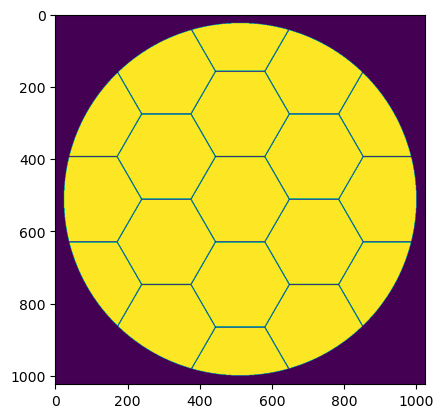

In [4]:
from astropy.io import fits

# Load Aperture
circle_mask = fits.getdata('/Users/jashcraft/Downloads/hex_pupil_amplitude_6510mm_1024pix.fits')
# circle_mask = fits.getdata('/Users/jashcraft/Downloads/key_pupil_amplitude_6510mm.fits')
plt.imshow(circle_mask)
PUPIL_NPIX = circle_mask.shape[0]

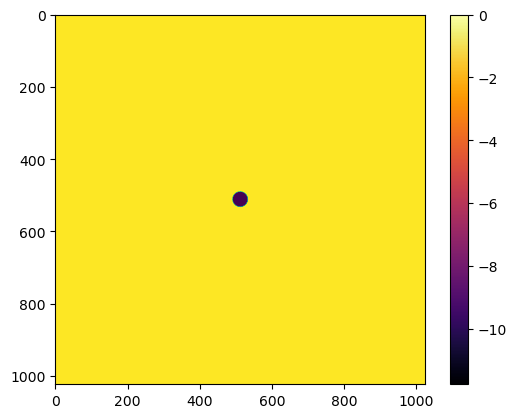

In [5]:
from prysm.propagation import focus_fixed_sampling,focus_fixed_sampling_backprop
from prysm import coordinates, geometry

img_dx = WVL * (EFL / EPD) / OS
pupil_dx = EPD / PUPIL_NPIX
# now set up the focal plane mask
psf = focus_fixed_sampling(wavefunction=circle_mask,
                           input_dx=pupil_dx,
                           prop_dist=EFL,
                           wavelength=WVL,
                           output_dx=img_dx,
                           output_samples=IMG_NPIX)

from dygdug.models import ImgSamplingSpec, one_sided_annulus

lambd = EFL / EPD * WVL  # um
iss = ImgSamplingSpec(IMG_NPIX, lambd / OS, lambd)  # 10/lambd
dh = one_sided_annulus(iss, IWA,
                            OWA, 
                            AZMIN,
                            AZMAX)
dh = np.fliplr(dh)
psf_I = np.abs(psf)**2
plt.imshow(dh * np.log10(psf_I/psf_I.max()+1e-16),cmap='inferno')
plt.colorbar()

# create the core mask
def inner_core_mask(iss, iwa):

    x, y = coordinates.make_xy_grid(iss.N, dx=iss.dx)
    r, t = coordinates.cart_to_polar(x, y)
    iwa = iwa * iss.lamD
    mask = geometry.circle(iwa, r)

    return mask

def knife_edge_mask(iss, iwa):
    x, y = coordinates.make_xy_grid(iss.N, dx=iss.dx)
    iwa = iwa * iss.lamD
    mask = x > iwa

    return mask

def circular_mask(iss, iwa):
    x, y = coordinates.make_xy_grid(iss.N, dx=iss.dx)
    r, t = coordinates.cart_to_polar(x, y)
    iwa = iwa * iss.lamD
    mask = r > iwa

    return mask

def lyot_mask(pupil_npix, pupil_dx, frac):

    x, y = coordinates.make_xy_grid(pupil_npix, dx=pupil_dx)
    r, t = coordinates.cart_to_polar(x, y)
    rnorm = r / (r.max() * np.sqrt(2))
    ls = np.zeros_like(x)
    ls[rnorm < frac/2] = 1

    return ls


# mask transmits inner 1.5 L/D
inner_mask = inner_core_mask(iss, 1.5)
focal_plane_mask = circular_mask(iss, IWA)
ls_mask = lyot_mask(circle_mask.shape[0], pupil_dx=pupil_dx, frac=0.85)
plt.imshow(focal_plane_mask)

In [16]:
from dygdug.vappid import APLCOptimizer2

# let's make a few instances 
optimizers = []
for wvl in band:

    aplc = APLCOptimizer2(amp=circle_mask,
                        amp_dx=pupil_dx,
                        efl=EFL, 
                        wvl=wvl, 
                        basis=None, 
                        dark_hole=dh,
                        dh_target=0,
                        dh_dx=img_dx,
                        fpm=focal_plane_mask,
                        ls=ls_mask)

    aplc.set_optimization_method(zonal=True)
    optimizers.append(aplc)
print(aplc.zonal)

# make a wrapper that calls fwd/reverse
class APLCWrapper:
    def __init__(self,optlist):

        """optlist is a list of APLCOptimizer2 instances"""

        self.optlist = optlist
        
        # init f and g
        self.f = 0
        self.g = 0

    def refresh(self):
        self.f = 0
        self.g = 0

    def fg(self,x):
        
        # reset the f, g values
        self.refresh()

        # just sum them
        for opt in self.optlist:
            f, g = opt.fg(x)
            self.f += f
            self.g += g

        return self.f, self.g

# make sure these work'
# aplc.fwd(np.random.random(aplc.amp[aplc.amp_select].shape))
# aplc.rev(np.random.random(aplc.amp[aplc.amp_select].shape))

True


In [17]:
aplc_broadband = APLCWrapper(optimizers)

In [18]:
aplc_broadband.fg(x0)

(13402.299512571411,
 array([-0.15500448, -0.15498084, -0.15499621, ..., -0.15498984,
        -0.15497419, -0.15499754]))

In [19]:
f0, g0 = 0,0
for opt in aplc_broadband.optlist:
    f,g = opt.fg(x0)
    print(f)
    print(g)
    f0 += f
    g0 += g
print(f0)
print(g0)

1077.0284364504087
[-0.02490745 -0.02481088 -0.02472244 ... -0.02472313 -0.02481159
 -0.02490819]
1854.0501961200532
[-0.04621108 -0.04617374 -0.04613397 ... -0.04613342 -0.04617317
 -0.04621048]
2869.3430626486193
[-0.04942408 -0.04944986 -0.0494762  ... -0.04947452 -0.04944811
 -0.04942225]
3677.6367334488546
[-0.03130686 -0.03137091 -0.03145235 ... -0.03144999 -0.03136845
 -0.03130429]
3924.2410839034756
[-0.00315501 -0.00317545 -0.00321125 ... -0.00320878 -0.00317287
 -0.00315232]
13402.299512571411
[-0.15500448 -0.15498084 -0.15499621 ... -0.15498984 -0.15497419
 -0.15499754]


In [20]:
from prysm.x.optym import F77LBFGSB
from scipy.optimize import minimize

x0 = np.ones(aplc.amp.shape, dtype=float)[aplc.amp_select]
x0 = np.ascontiguousarray(x0)
opt = F77LBFGSB(aplc_broadband.fg, x0, memory=10, upper_bounds=np.ones(x0.shape), lower_bounds=np.zeros(x0.shape))
opt.iprint = 0
# takes roughly 500 iters for ~1e-11 at 1024npup and one wavelength
for _ in range(10):
    opt.step()

# results = minimize(aplc_broadband.fg,x0=x0,method='L-BFGS-B',jac=True,
#                    options={'maxiter':10,'maxls':60,'iprint':0})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       732197     M =           10


In [22]:
# from scipy.optimize import show_options
# show_options()
opt.x

array([0.93256735, 0.93245461, 0.93234976, ..., 0.93234328, 0.93244788,
       0.93256036])

In [26]:
newmask = aplc.amp
newmask[aplc.amp_select] = opt.x

In [63]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where ``x`` is a 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where ``n`` is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see he

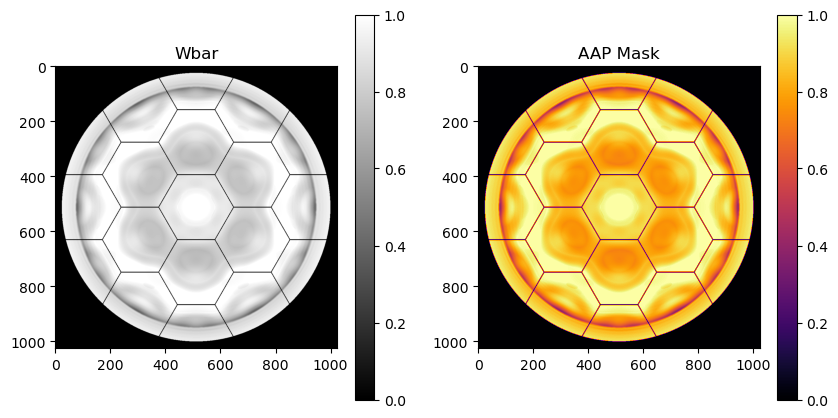

In [28]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Wbar')
plt.imshow(aplc.amp,cmap='gray')
plt.colorbar()
plt.subplot(122)
plt.title('AAP Mask')
plt.imshow(newmask,cmap='inferno') 
plt.colorbar()
plt.show()

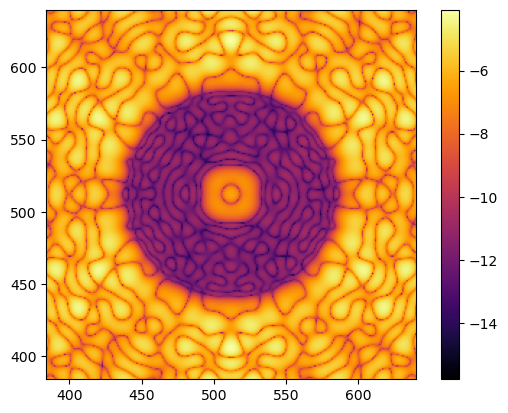

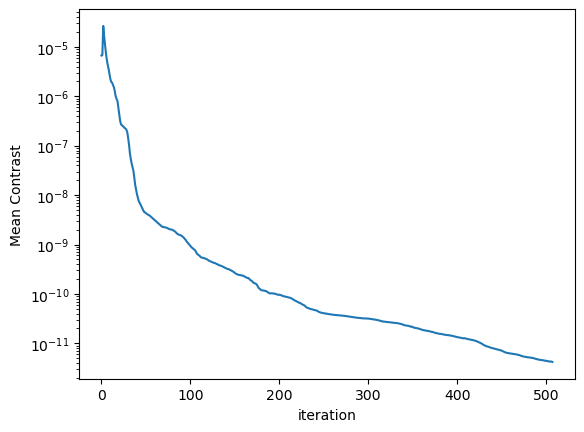

In [10]:
cut = 128
contrast_norm = np.abs(aplc.B)**2
contrast_norm = contrast_norm.max()
plt.imshow(np.log10(aplc.I/contrast_norm) ,cmap='inferno')
plt.xlim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.ylim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.colorbar()
plt.show()

plt.plot(aplc.cost/contrast_norm)
plt.ylabel('Mean Contrast')
plt.xlabel('iteration')
plt.yscale('log')
plt.show()

/var/folders/xs/d1q2b9xj0j35ml7lb2vmfb240000gn/T/ipykernel_68824/3597519794.py:4: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.abs(aplc.C)**2 /focal_field_irrad.max()), # field before FPM


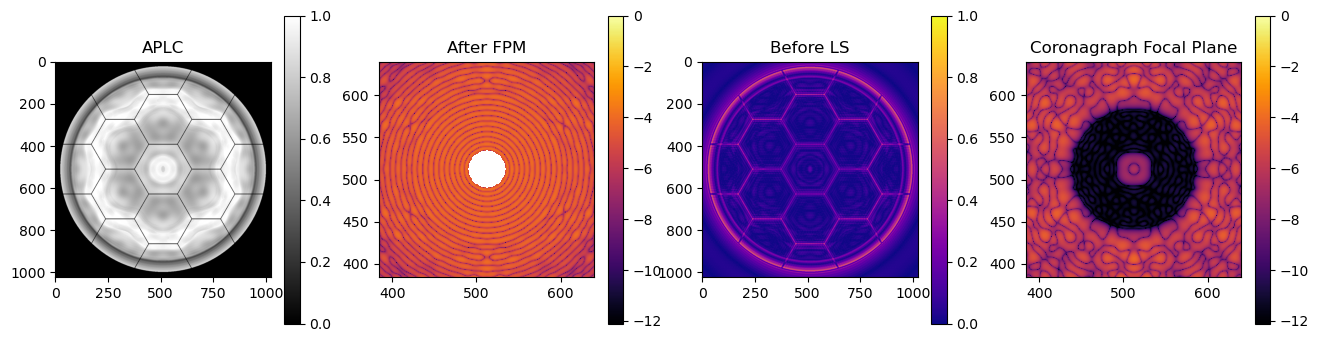

In [11]:
focal_field_irrad = np.abs(aplc.B)**2

data = [aplc.aplc, # apodizer
        np.log10(np.abs(aplc.C)**2 /focal_field_irrad.max()), # field before FPM
        np.abs(aplc.c), # field before LS
        np.log10(aplc.I/focal_field_irrad.max())] # field at coronagraph focal plane

titles = ['APLC','After FPM','Before LS','Coronagraph Focal Plane']
cmaps = ['gray','inferno','plasma','inferno']

vmins = [0,0,0,0]
vmaxs = [1,-11,1,-11]

lim = [None,128,None,128]

plt.figure(figsize=[16,4])
for i,(d,tit,vmin,vmax,cut,cmap) in enumerate(zip(data,titles,vmins,vmaxs,lim,cmaps)):
    plt.subplot(1,4,i+1)
    plt.title(tit)
    plt.imshow(d,cmap=cmap,vmin=vmin,vmax=vmax)
    if i == 1 or i == 3:
        plt.xlim(d.shape[0]/2 - cut,d.shape[0]/2 + cut)
        plt.ylim(d.shape[0]/2 - cut,d.shape[0]/2 + cut)
    plt.colorbar() 
plt.show()

In [16]:
from astropy.io import fits

fits.writeto('ls_circular_1024pix.fits',ls_mask)

In [230]:
np.sum(aplc.aplc)/np.sum(circle_mask)

0.7255776423294735

In [167]:
tilts = [0]# np.arange(0,13,1)
psf_energy = []
for TILT_WAVES in tilts:
    # TILT_WAVES *= -
    xx, yy = coordinates.make_xy_grid(aplc.aplc.shape,dx=pupil_dx)
    tilt_aberr = np.exp(-1j * np.pi * xx / xx.max()  * TILT_WAVES)

    before_fpm = focus_fixed_sampling(
                wavefunction=aplc.aplc * tilt_aberr,
                input_dx=pupil_dx,
                prop_dist = EFL,
                wavelength= WVL * 0.9,
                output_dx= img_dx,
                output_samples=dh.shape,
                shift=(0, 0),
                method='mdft')

    before_ls = focus_fixed_sampling(
                wavefunction=before_fpm * knife_mask,
                input_dx=img_dx,
                prop_dist = EFL,
                wavelength= WVL * 0.9,
                output_dx= pupil_dx,
                output_samples=aplc.aplc.shape,
                shift=(0, 0),
                method='mdft')

    coro_img_onax = focus_fixed_sampling(
                wavefunction=before_ls * ls_mask,
                input_dx=pupil_dx,
                prop_dist = EFL,
                wavelength= WVL * 0.9,
                output_dx= img_dx,
                output_samples=dh.shape,
                shift=(0, 0),
                method='mdft')
    
    I = np.abs(coro_img_ofax)**2 / contrast_norm.max()
    psf_energy.append(np.sum(I))

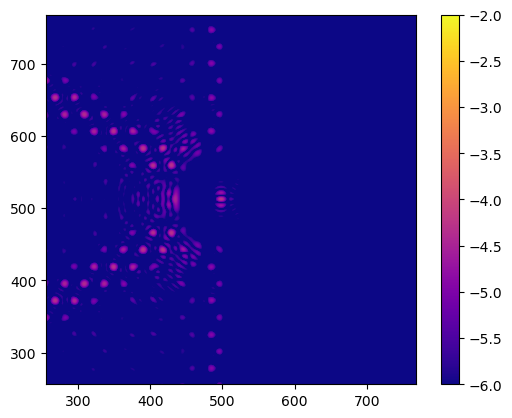

In [172]:
cut = 256
plt.style.use('default')
psf_sum = np.abs(coro_img_onax)**2 #+ 1e-5 * np.abs(coro_img_ofax)**2
before_fpm_irrad = np.abs(before_fpm)**2
plt.imshow(np.log10(psf_sum/contrast_norm), vmin=-6,vmax=-2, cmap='plasma')
plt.xlim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.ylim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.colorbar()

In [169]:
WVL * 0.9

0.5904

(256.0, 768.0)

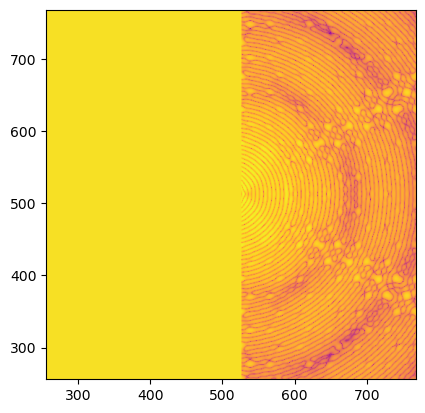

In [170]:
plt.imshow(np.log10(np.abs(before_fpm)**2) * knife_mask,cmap='plasma')
plt.xlim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)
plt.ylim(IMG_NPIX/2 - cut, IMG_NPIX/2 + cut)

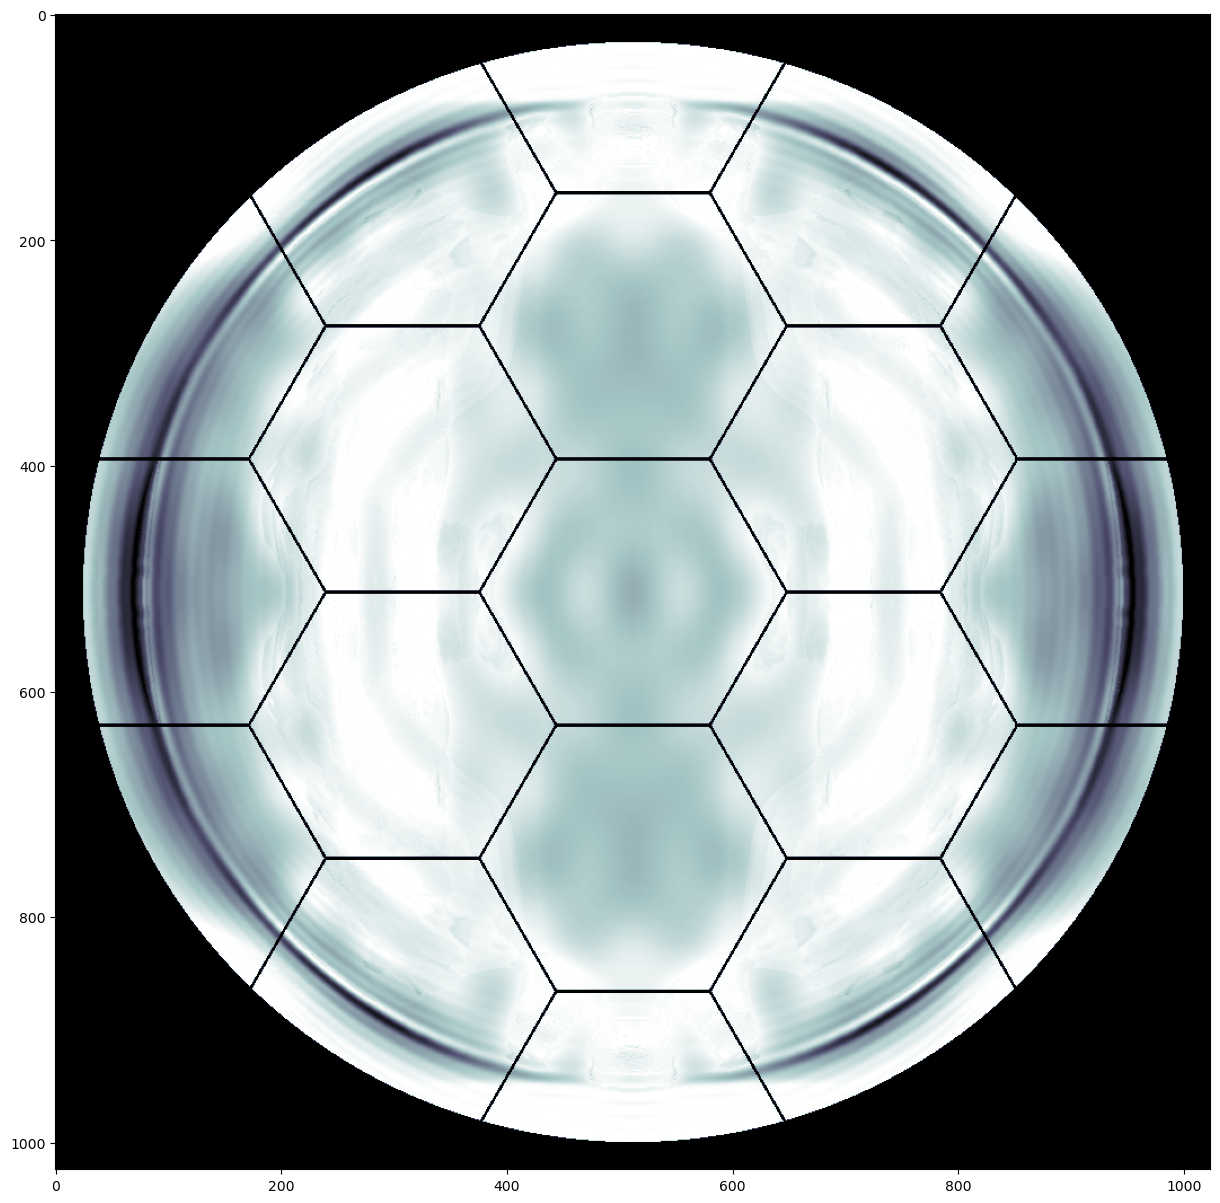

In [147]:
plt.figure(figsize=[15,15])
plt.imshow(aplc.aplc,cmap='bone')

In [102]:
np.sum(aplc.aplc) / np.sum(circle_mask)

0.8287855129443662

(0.0, 12.5)

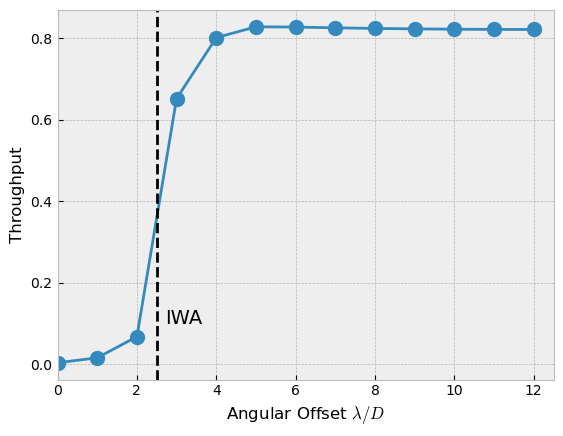

In [105]:
plt.style.use('bmh')
plt.plot(tilts,psf_energy/(np.sum(focal_field_irrad)/contrast_norm),marker='o',markersize=10)
plt.axvline(2.5, color='black', linestyle='dashed')
plt.ylabel('Throughput')
plt.xlabel('Angular Offset '+r'$\lambda / D$')
plt.text(2.7,0.1,s='IWA',fontsize=14)
plt.xlim(0,12.5)

I bet this can do the bridge 4 glyph

In [199]:
import imageio.v3 as iio



pth = '/Users/jashcraft/Desktop/bridge4.png'
im = iio.imread(pth)
print(im.shape)
im = np.float64(im)
im /= im.max()

# make it square
im = im[:,int(1598/2)-int(1374/2):int(1598/2)+int(1374/2)]
dh_bridge_4 = (1 - (im[...,0])).astype(bool)

(1374, 1598, 4)


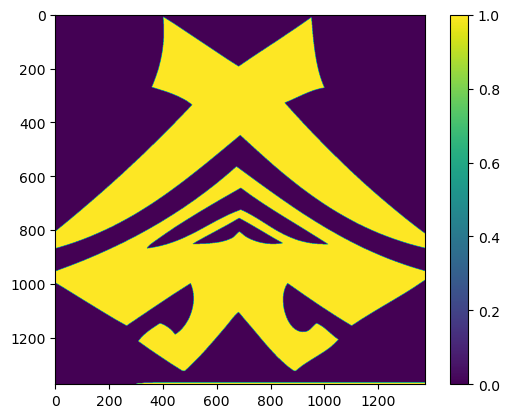

In [200]:
plt.imshow(dh_bridge_4)
plt.colorbar()

In [201]:
iss_b4 = ImgSamplingSpec(dh_bridge_4.shape[0], lambd / OS, lambd)  # 10/lambd
kf_bf = knife_edge_mask(iss_b4,iwa=0)

aplc = APLCOptimizer2(amp=circle_mask,
                      amp_dx=pupil_dx,
                      efl=EFL, 
                      wvl=WVL, 
                      basis=None, 
                      dark_hole=dh_bridge_4,
                      dh_target=0,
                      dh_dx=img_dx,
                      fpm=kf_bf,
                      ls=ls_mask)

aplc.zonal = True

x0 = np.ones(aplc.amp.shape, dtype=float)[aplc.amp_select]
x0 = np.ascontiguousarray(x0)
opt = F77LBFGSB(aplc.fg, x0, memory=10, upper_bounds=np.ones(x0.shape), lower_bounds=np.zeros(x0.shape))
opt.iprint = 0

In [202]:
for _ in range(50):
    opt.step()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       732197     M =           10


ValueError: operands could not be broadcast together with shapes (1374,1374) (1024,1024) 

(1374, 1374)

In [196]:
kf_bf.shape

(1024, 1024)